# Decision trees and NN tryouts on SPR data

Load training and validation data as 
    month : [ Features | Targets| Difference | Last Choice Targets  ]
    

In [1]:
# https://ipython.org/ipython-doc/3/config/extensions/autoreload.html
%load_ext autoreload
%autoreload 2

In [2]:
import os
import numpy as np
import pandas as pd

import logging
logging.getLogger().handlers = []
logging.basicConfig(level=logging.INFO)

import matplotlib.pylab as plt
%matplotlib inline

/usr/local/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [3]:
import sys
sys.path.append("../common")

from dataset import load_trainval, LC_TARGET_LABELS, TARGET_LABELS_FRQ, TARGET_LABELS_DIFF
from utils import to_yearmonth, TARGET_LABELS, TARGET_LABELS2
from utils import target_str_to_labels, decimal_to_dummies, targets_str_to_indices, targets_dec_to_indices

In [4]:
features = [
    u'ind_empleado', u'pais_residencia',
    u'sexo', u'age', u'ind_nuevo', u'antiguedad', u'indrel',
    u'ult_fec_cli_1t', u'indrel_1mes', u'tiprel_1mes', u'indresi',
    u'indext', u'conyuemp', u'canal_entrada', u'indfall', u'nomprov',
    u'ind_actividad_cliente', u'renta', u'segmento'    
]

In [5]:
# # train_yearmonths_list = [201504, 201505, 201604]
# train_yearmonths_list = [201505, 201605]
# # train_yearmonths_list = [201505]
# #val_yearmonth = [201605]
# train_nb_clients = 15000
# # train_nb_clients = 1500
# #train_df, val_df = load_trainval(train_yearmonths_list, val_yearmonth, train_nb_clients, val_nb_clients=1500)
# train_df = load_trainval(train_yearmonths_list, train_nb_clients=train_nb_clients)

filename = "trainval_201505+201602+201605__150000.csv"
train_df = pd.read_csv('../data/generated/' + filename)

Display loaded data

In [6]:
# train_df[['fecha_dato', 'ncodpers'] + TARGET_LABELS_FRQ.tolist()].head(10)

Useful structures

In [7]:
def get_common_clients(df1, mask1, mask2, df2=None):
    active_clients1 = df1[mask1]['ncodpers'].unique()
    if df2 is not None:
        active_clients2 = df2[mask2]['ncodpers'].unique()
    else:
        active_clients2 = df1[mask2]['ncodpers'].unique()
    active_clients = list(set(active_clients1) & set(active_clients2)) 
    
    if df2 is not None:
        return df1['ncodpers'].isin(active_clients), df2['ncodpers'].isin(active_clients)
    return df1['ncodpers'].isin(active_clients)

In [8]:
months_ym_map = {}
# months = list(set(train_df['fecha_dato'].unique()) | set(val_df['fecha_dato'].unique()))
months = train_df['fecha_dato'].unique()
for m in months:
    months_ym_map[to_yearmonth(m)] = m

        
train_months = train_df['fecha_dato'].unique()
# val_months = val_df['fecha_dato'].unique()
    

### Train a model

In [9]:
from utils import get_added_products, remove_last_choice, apk, map7_score
from visualization import visualize_train_test, visualize_folds, compare_two_datasets, compare_folds, compare_folds2

In [10]:
target_features = ['targets_diff', 'targets_logdiff', 'targets_logcount2_diff', 'targets_logcount2', 'targets_logcount1', 'targets_logDec']
TARGET_LABELS_FRQ_PREV = [c + '_prev' for c in TARGET_LABELS_FRQ]

In [11]:
def get_XY(current_month, df1, next_year_month, df2, months_ym_map):
    month_mask = df1['fecha_dato'] == months_ym_map[current_month]
    next_year_month_mask = df2['fecha_dato'] == months_ym_map[next_year_month]
    next_year_prev_month_mask = df2['fecha_dato'] == months_ym_map[next_year_month - 1]
    
    # get common clients from df1 at this month and df2 at next year month
    common_clients_mask1, common_clients_mask2 = get_common_clients(df1, month_mask, next_year_month_mask, df2)
    common_clients_mask2, common_clients_mask3 = get_common_clients(df2, common_clients_mask2 & next_year_month_mask, next_year_prev_month_mask, df2)
        
    c1 = df1[common_clients_mask1 & month_mask]['ncodpers'].values
    c2 = df2[common_clients_mask2 & next_year_month_mask]['ncodpers'].values
    c3 = df2[common_clients_mask3 & next_year_prev_month_mask]['ncodpers'].values
    assert (c1 == c2).all() and (c2 == c3).all(), "Problem with common clients" 
    
    X = df1[common_clients_mask1 & month_mask][['ncodpers', 'fecha_dato'] + target_features + features + TARGET_LABELS_FRQ.tolist()]            
   
    if TARGET_LABELS[0] in df2.columns and TARGET_LABELS_DIFF[0] in df2.columns and not df2[next_year_month_mask][TARGET_LABELS].isnull().all().all():
        Y = df2[common_clients_mask2 & next_year_month_mask][['ncodpers', 'fecha_dato', 'targets_str', 'lc_targets_str', 'targets_diff'] + TARGET_LABELS + TARGET_LABELS_DIFF.tolist()]    
        assert (X['ncodpers'].values == Y['ncodpers'].values).all(), "There is a problem in alignment"
        Y.index = X.index                
    else:
        Y = None
        
    if TARGET_LABELS_FRQ[0] in df2.columns and not df2[next_year_prev_month_mask][TARGET_LABELS].isnull().all().all():
        # Add TARGET_LABELS_FRQ from previous month to X:
        target_labels_frq = df2[common_clients_mask3 & next_year_prev_month_mask][['ncodpers'] + TARGET_LABELS_FRQ.tolist()]
        assert (X['ncodpers'].values == target_labels_frq['ncodpers'].values).all(), "There is a problem in alignment"
        target_labels_frq = target_labels_frq[TARGET_LABELS_FRQ]
        target_labels_frq.columns = TARGET_LABELS_FRQ_PREV
        target_labels_frq.index = X.index
        X = pd.concat([X, target_labels_frq], axis=1)        

    
    if LC_TARGET_LABELS[0] in df2.columns:
        clients_last_choice = df2[common_clients_mask2 & next_year_month_mask][['ncodpers', 'fecha_dato', 'targets_str'] + LC_TARGET_LABELS.tolist()]
    else:
        clients_last_choice = None
        
    return X, Y, clients_last_choice


In [12]:
current_month = 201505
next_year_month = current_month + 100

df1 = train_df if months_ym_map[current_month] in train_months else val_df
#df1 = train_df
df2 = train_df if months_ym_map[next_year_month] in train_months else val_df
#df2 = train_df

X, Y, clients_last_choice = get_XY(current_month, df1, next_year_month, df2, months_ym_map)

In [13]:
assert (X['ncodpers'].values == Y['ncodpers'].values).all(), "WTF"
assert (X['ncodpers'].values == clients_last_choice['ncodpers'].values).all(), "WTF"

In [14]:
print X.shape
X.head(10)

(149983, 75)


,ncodpers,fecha_dato,targets_diff,targets_logdiff,targets_logcount2_diff,targets_logcount2,targets_logcount1,targets_logDec,ind_empleado,pais_residencia,...,ind_hip_fin_ult1_frq_prev,ind_plan_fin_ult1_frq_prev,ind_pres_fin_ult1_frq_prev,ind_reca_fin_ult1_frq_prev,ind_tjcr_fin_ult1_frq_prev,ind_valo_fin_ult1_frq_prev,ind_viv_fin_ult1_frq_prev,ind_nomina_ult1_frq_prev,ind_nom_pens_ult1_frq_prev,ind_recibo_ult1_frq_prev
1,15889,2015-05-28,32.0,3.496508,-0.00042,0.000047,0.000053,14.571618,0,0,...,0.992618,0.987667,0.996794,0.931887,0.94339,0.033643,0.995141,0.932789,0.927527,0.839655
7,15893,2015-05-28,0.0,0.000000,0.00000,0.001413,0.001453,2.833213,1,0,...,0.992618,0.987667,0.996794,0.931887,0.94339,0.033643,0.995141,0.932789,0.927527,0.839655
13,15895,2015-05-28,0.0,0.000000,0.00000,0.000002,0.000007,14.781716,2,0,...,0.992618,0.012333,0.996794,0.068113,0.05661,0.033643,0.995141,0.932789,0.927527,0.160345
19,15897,2015-05-28,-2.0,-1.098612,0.00000,0.000002,0.000007,14.805207,2,0,...,0.992618,0.012333,0.996794,0.068113,0.05661,0.033643,0.995141,0.932789,0.072473,0.160345
25,15900,2015-05-28,0.0,0.000000,0.00000,0.000261,0.000307,13.287691,3,0,...,0.992618,0.987667,0.996794,0.068113,0.94339,0.966357,0.995141,0.932789,0.927527,0.160345
31,15916,2015-05-28,0.0,0.000000,0.00000,0.000007,0.000007,13.234752,3,0,...,0.992618,0.012333,0.996794,0.068113,0.05661,0.033643,0.995141,0.932789,0.927527,0.160345
37,15919,2015-05-28,0.0,0.000000,0.00000,0.000058,0.000047,14.588785,3,0,...,0.992618,0.987667,0.996794,0.068113,0.94339,0.966357,0.995141,0.932789,0.927527,0.160345
43,15920,2015-05-28,0.0,0.000000,0.00000,0.000052,0.000100,14.803952,0,0,...,0.992618,0.987667,0.996794,0.068113,0.94339,0.033643,0.995141,0.932789,0.927527,0.160345
49,15921,2015-05-28,0.0,0.000000,0.00000,0.000002,0.000007,13.296737,0,0,...,0.992618,0.012333,0.996794,0.931887,0.05661,0.033643,0.995141,0.932789,0.927527,0.160345
55,15922,2015-05-28,0.0,0.000000,0.00000,0.000064,0.000067,14.586867,3,0,...,0.992618,0.987667,0.996794,0.931887,0.94339,0.966357,0.004859,0.932789,0.927527,0.160345


In [15]:
print Y.shape
Y[Y['targets_diff'] > 0][['fecha_dato', 'ncodpers', 'targets_str', 'lc_targets_str'] + TARGET_LABELS_DIFF.tolist() ].head(10)

(149983, 53)


,fecha_dato,ncodpers,targets_str,lc_targets_str,ind_ahor_fin_ult1_diff,ind_aval_fin_ult1_diff,ind_cco_fin_ult1_diff,ind_cder_fin_ult1_diff,ind_cno_fin_ult1_diff,ind_ctju_fin_ult1_diff,...,ind_hip_fin_ult1_diff,ind_plan_fin_ult1_diff,ind_pres_fin_ult1_diff,ind_reca_fin_ult1_diff,ind_tjcr_fin_ult1_diff,ind_valo_fin_ult1_diff,ind_viv_fin_ult1_diff,ind_nomina_ult1_diff,ind_nom_pens_ult1_diff,ind_recibo_ult1_diff
1,2016-05-28,15889,001000001000000000110000,001000001000000000010000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
139,2016-05-28,15988,001000000000000000100000,001000000000000000000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
433,2016-05-28,16525,001010001000110100100111,001010000000110100100111,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
589,2016-05-28,16680,000010000000000011000111,000000000000000011000111,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
655,2016-05-28,16826,001000000000000000001001,001000000000000000001000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
811,2016-05-28,17151,000010010000001001110111,000010010000001001010111,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
877,2016-05-28,17231,001000000000000001110001,001000000000000001010001,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1039,2016-05-28,17458,001000000000000000010000,000000000000000000010000,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1111,2016-05-28,17525,000010011001010000100110,000010011001010000100001,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
1123,2016-05-28,17528,000010000001100001110111,000010000001100001110011,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [16]:
print clients_last_choice.shape
clients_last_choice.head(10)

(149983, 27)


,ncodpers,fecha_dato,targets_str,lc_ind_ahor_fin_ult1,lc_ind_aval_fin_ult1,lc_ind_cco_fin_ult1,lc_ind_cder_fin_ult1,lc_ind_cno_fin_ult1,lc_ind_ctju_fin_ult1,lc_ind_ctma_fin_ult1,...,lc_ind_hip_fin_ult1,lc_ind_plan_fin_ult1,lc_ind_pres_fin_ult1,lc_ind_reca_fin_ult1,lc_ind_tjcr_fin_ult1,lc_ind_valo_fin_ult1,lc_ind_viv_fin_ult1,lc_ind_nomina_ult1,lc_ind_nom_pens_ult1,lc_ind_recibo_ult1
5,15889,2016-05-28,001000001000000000110000,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
11,15893,2016-05-28,000000000000000000010000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
17,15895,2016-05-28,001000000000100101110001,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0
23,15897,2016-05-28,000010010000110101110011,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0
29,15900,2016-05-28,000000010000000001000001,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
35,15916,2016-05-28,000010001000100101110001,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0
41,15919,2016-05-28,001000000001000001000001,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
47,15920,2016-05-28,001000010000000001010001,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
53,15921,2016-05-28,001000010001010100110001,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0
59,15922,2016-05-28,001000010000000000001001,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0


## Another train/predict + CV implementation

### Input

- `X` : `[nb_samples, nb_features]` shaped pd.DataFrame
    - `features_masks_list` : `{fm1_name: features_mask_1, fm2_name: features_mask_2, ...]` with `features_mask_i` is a list of feature column names. They can oversect.
    
- `Y` : `[nb_samples, nb_labels]` shaped pd.DataFrame
    - `labels_masks_list` : `{lm1_name: labels_mask_1, lm2_name: labels_mask_2, ...}` with `labels_mask_i` is a list of labels column names. They can oversect.

- `samples_masks_list` : `[samples_mask_1, samples_mask_2, ...]` with samples_mask_i is a function to produce a boolean pd.DataFrame . Used only for training. 


- Set of models `models` : list of functions to create a model, e.g. `[create_RF, create_NN, create_GBT]`


### Training phase




In [17]:
from collections import defaultdict
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier

In [18]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Merge
from keras.utils import np_utils

from keras.wrappers.scikit_learn import KerasClassifier

Using Theano backend.


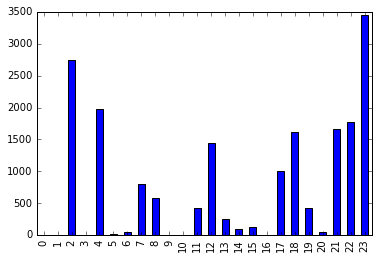

In [36]:
mask = Y['targets_diff'] > 0
targets_index_counts = np.zeros((len(TARGET_LABELS)))
for i, c in enumerate(TARGET_LABELS):
    s = (Y[mask][c] > 0).sum()
    targets_index_counts[i] = s

targets_index_counts = pd.Series(targets_index_counts)
targets_index_counts.plot.bar()

In [123]:
samples_masks_list = [
#     lambda x, y:  ~(x['targets_diff'].isin([0])) | ~(y['targets_diff'].isin([0])), 
#     lambda x, y:  (x['targets_diff'] > 0) | (y['targets_diff'] > 0), 
    lambda x, y:  (y['targets_diff'] > 0), 
]

features_masks_dict = {
#     'fm_all': features + target_features + TARGET_LABELS_FRQ.tolist() + TARGET_LABELS_FRQ_PREV,
    'fm0': features + TARGET_LABELS_FRQ.tolist(),
#     'fm1': ['pais_residencia', 'sexo', 'age', 'ind_nuevo', 'segmento', 'ind_empleado', 'ind_actividad_cliente', 'indresi'],
    'fm1': TARGET_LABELS_FRQ_PREV,
    'fm2': target_features,
    'fm3': ['pais_residencia', 'sexo', 'age', 'segmento', 'renta'],
#     'fm4': ['pais_residencia', 'sexo', 'age', 'renta', 'targets_logdiff', 'targets_logcount2_diff','targets_logcount2','targets_logcount1'],
    'fm5': ['nomprov', 'ind_nuevo', 'renta', 'ind_actividad_cliente', 'canal_entrada'],
#     'fm6': TARGET_LABELS_FRQ,
}

In [124]:
# https://www.analyticsvidhya.com/blog/2016/02/complete-guide-parameter-tuning-gradient-boosting-gbm-python/

def create_RF(input_shape, output_shape):        
    # https://www.analyticsvidhya.com/blog/2015/06/tuning-random-forest-model/
    return RandomForestClassifier(n_estimators=100, 
#                                   min_samples_split=100,
#                                   min_samples_leaf=25,
#                                   max_depth=10
                                  max_features=1.0, 
#                                   oob_score=True,
#                                   bootstrap=True,
                                  n_jobs=-1
                                 )

def create_ET(input_shape, output_shape):
    return ExtraTreesClassifier(n_estimators=100,
#                                   min_samples_leaf=25,
#                                   max_depth=10
                                  max_features=1.0, 
                                  oob_score=True,
                                  bootstrap=True,
                                  n_jobs=-1

                               )

def create_GB(input_shape, output_shape):
    return GradientBoostingClassifier(n_estimators=75)


def create_NN0(input_shape, output_shape):
        
    assert len(input_shape) == 2, "Input shape should be 2D"
    assert len(output_shape) == 2, "Input shape should be 2D"
    n_features = input_shape[1]
    output_dim = output_shape[1]
    
    def create_model(input_dim=n_features, output_dim=output_dim):
        model = Sequential()
        model.add(Dense(30, init='uniform', input_shape=(input_dim,), activation='relu'))
        model.add(Dropout(0.15))
#         model.add(Dense(output_dim, activation='sigmoid'))
        model.add(Dense(output_dim, activation='softmax'))
#         model.compile(loss='categorical_crossentropy', optimizer='nadam', metrics=['accuracy'])
        model.compile(loss='binary_crossentropy', optimizer='nadam', metrics=['accuracy'])
        return model

    return KerasClassifier(build_fn=create_model, nb_epoch=200, batch_size=2000, verbose=0)
    

models_dict = {
    'rf': create_RF,
    'et': create_ET,
    'gb': create_GB,
#     'nn0': create_NN0
}

In [125]:
print mask.sum()
print targets_index_counts[targets_index_counts > 100].index

46667
Int64Index([2, 4, 7, 8, 11, 12, 13, 15, 17, 18, 19, 21, 22, 23], dtype='int64')


In [126]:
NP_TARGET_LABELS = np.array(TARGET_LABELS)
target_labels = NP_TARGET_LABELS

common_groups = [
    [2, 4, 7, 8, 11, 12, 13, 15, 17, 18, 19, 21, 22, 23],
#     [2, 4],    
#     [2, 6, 7, 8],
#     [2, 18, 23, 12], 
#     [21, 22],
#     [2, 12, 18],
#     [2, 12, 23],
#     [2, 18, 23],
#     [18, 23, 21, 22],
#     [21, 23, 22, 4],
#     [3, 4], 
#     [22, 7, 8, 23],
#     [0, 1, 14, 15, 17]
]

common_groups += [[i] for i in [2, 4, 7, 8, 11, 12, 13, 15, 17, 18, 19, 21, 22, 23]]



def flatten(array):
    out = []
    for item in array:
        out += item
    return out

others = list(set(range(24)) - set(flatten(common_groups)))

# for i, a in enumerate(zip(TARGET_LABELS2, TARGET_LABELS)):
#     print i, a
    
s = set({})
labels_masks_dict = {}
for i, g in enumerate(common_groups):
    print 'lm_%i' % i, " <=> ", g, "<==>", TARGET_LABELS2[g]
    labels_masks_dict['lm_%i' % i] = target_labels[g]
    s |= set(g)
    
# print 'lm_others', "<=>", others, "<==>", TARGET_LABELS2[others]
# labels_masks_dict['lm_others'] = target_labels[others]
# s |= set(others)

# assert len(s) == len(target_labels), "Sum is not equal 24, s=%i" % s
print labels_masks_dict

lm_0  <=>  [2, 4, 7, 8, 11, 12, 13, 15, 17, 18, 19, 21, 22, 23] <==> ['Current Accounts' 'Payroll Account' 'particular Account'
 'particular Plus Account' 'Long-term deposits' 'e-account' 'Funds'
 'Pensions (plan fin)' 'Taxes' 'Credit Card' 'Securities' 'Payroll'
 'Pensions' 'Direct Debit']
lm_1  <=>  [2] <==> ['Current Accounts']
lm_2  <=>  [4] <==> ['Payroll Account']
lm_3  <=>  [7] <==> ['particular Account']
lm_4  <=>  [8] <==> ['particular Plus Account']
lm_5  <=>  [11] <==> ['Long-term deposits']
lm_6  <=>  [12] <==> ['e-account']
lm_7  <=>  [13] <==> ['Funds']
lm_8  <=>  [15] <==> ['Pensions (plan fin)']
lm_9  <=>  [17] <==> ['Taxes']
lm_10  <=>  [18] <==> ['Credit Card']
lm_11  <=>  [19] <==> ['Securities']
lm_12  <=>  [21] <==> ['Payroll']
lm_13  <=>  [22] <==> ['Pensions']
lm_14  <=>  [23] <==> ['Direct Debit']
{'lm_12': array(['ind_nomina_ult1'], 
      dtype='|S17'), 'lm_13': array(['ind_nom_pens_ult1'], 
      dtype='|S17'), 'lm_10': array(['ind_tjcr_fin_ult1'], 
      dty

In [127]:
# {model_name: [(samples_mask_code, features_mask_name, labels_mask_name), ...]}
models_pipelines = {
    'gb' : [(None, None, key) for key in labels_masks_dict if len(labels_masks_dict[key]) == 1],    
    'rf' : [(None, None, key) for key in labels_masks_dict if len(labels_masks_dict[key]) > 1],
    'et' : [(None, None, key) for key in labels_masks_dict if len(labels_masks_dict[key]) > 1],
}
models_pipelines

{'et': [(None, None, 'lm_0')],
 'gb': [(None, None, 'lm_12'),
  (None, None, 'lm_13'),
  (None, None, 'lm_10'),
  (None, None, 'lm_11'),
  (None, None, 'lm_14'),
  (None, None, 'lm_8'),
  (None, None, 'lm_9'),
  (None, None, 'lm_1'),
  (None, None, 'lm_2'),
  (None, None, 'lm_3'),
  (None, None, 'lm_4'),
  (None, None, 'lm_5'),
  (None, None, 'lm_6'),
  (None, None, 'lm_7')],
 'rf': [(None, None, 'lm_0')]}

In [128]:
from trainval import train_all, predict_all, probas_to_indices, score_estimators
from utils import map7_score0

In [129]:
ll = 140000
# ll = 1100

mask = (X.index.isin((X.index[:ll//3]))) | (X.index.isin((X.index[2*ll//3:])))

X1 = X[mask]
Y1 = Y[mask]
clc1 = clients_last_choice[mask]
print X1.shape, Y1.shape, clc1.shape

mask = X.index.isin(X.index[ll//3:2*ll//3])
X2 = X[mask]
Y2 = Y[mask]
clc2 = clients_last_choice[mask]
print X2.shape, Y2.shape, clc2.shape

(103316, 75) (103316, 53) (103316, 27)
(46667, 75) (46667, 53) (46667, 27)


In [130]:
# res = Y1[labels_masks_dict['lm_0']].apply(dummies_to_decimal, axis=1)
# res = pd.get_dummies(res)
# res.head()

In [131]:
from utils import dummies_to_decimal
from sklearn.preprocessing import StandardScaler


def prepare_to_fit(X_train, Y_train):    
    x_train = X_train.values
    x_train = StandardScaler().fit_transform(x_train)
    y_train = Y_train.apply(dummies_to_decimal, axis=1)
    y_train = pd.get_dummies(y_train)
    y_train = y_train.values    
    return x_train, y_train


def prepare_to_test(X_val, Y_val=None):
    x_val = X_val.values
    x_val = StandardScaler().fit_transform(x_val)
    if Y_val is not None:
        y_val = Y_val.apply(dummies_to_decimal, axis=1)
        y_val = pd.get_dummies(y_val)
        y_val = y_val.values 
    else:
        y_val = None
    return x_val, y_val


def probas_to_labels_probas(y_probas, class_indices, labels):
    l = len(labels)
    out = np.zeros((len(y_probas), l))
    i = 0
    for probas in y_probas:
        if np.sum(probas) > 0:
            pr = np.zeros((l,))
            for index, p in zip(class_indices, probas):
                dummies_str = decimal_to_dummies(index, l)
                pr += p * np.array([float(v) for v in dummies_str])
            out[i, :] = pr    
        i += 1
    return out
    

In [132]:
_kwargs = {
    'samples_masks_list': samples_masks_list, 
    'features_masks_dict': features_masks_dict, 
    'labels_masks_dict': labels_masks_dict, 
    'models_dict': models_dict,
    'labels': target_labels,
    'transform_proba_func': probas_to_indices,
#     'prepare_to_fit_func': prepare_to_fit,
#     'prepare_to_test_func': prepare_to_test,   
#     'probas_to_labels_probas_func': probas_to_labels_probas,
    'threshold': 0.15,
    'n_highest': 7,
    'mode': 'sum',
    'verbose': False,
    'models_pipelines': models_pipelines,
    'return_probas': True
}

In [133]:
estimators = train_all(X1, Y1, **_kwargs)

#print estimators

INFO:root:-- Train all --
INFO:root:-- Process : sample_mask=3293/103316, features_mask=fm5, labels_mask=lm_12
INFO:root:--- Score : model='gb', fit accuracy : 0.644397
INFO:root:-- Process : sample_mask=3293/103316, features_mask=fm5, labels_mask=lm_13
INFO:root:--- Score : model='gb', fit accuracy : 0.621925
INFO:root:-- Process : sample_mask=3293/103316, features_mask=fm5, labels_mask=lm_10
INFO:root:--- Score : model='gb', fit accuracy : 0.684179
INFO:root:-- Process : sample_mask=3293/103316, features_mask=fm5, labels_mask=lm_11
INFO:root:--- Score : model='gb', fit accuracy : 0.903735
INFO:root:-- Process : sample_mask=3293/103316, features_mask=fm5, labels_mask=lm_14
INFO:root:--- Score : model='gb', fit accuracy : 0.778621
INFO:root:-- Process : sample_mask=3293/103316, features_mask=fm5, labels_mask=lm_8
INFO:root:--- Score : model='gb', fit accuracy : 0.966596
INFO:root:-- Process : sample_mask=3293/103316, features_mask=fm5, labels_mask=lm_9
INFO:root:--- Score : model='gb',

In [134]:
accuracies = defaultdict(list)
for e in estimators:
    accuracies[e[0][2]].append(e[2])

mean_accuracy = {}
for key in accuracies:
    accuracy_list = accuracies[key]
    mean_accuracy[key] = sum(accuracy_list)/len(accuracy_list)
    
mean_accuracy

{'et': 0.58475554205891278,
 'gb': 0.86716411435512564,
 'rf': 0.58402672335256611}

In [135]:
_ = score_estimators(estimators, X2, Y2, **_kwargs)

INFO:root:-- Score : model=gb, features_mask=fm5, labels_mask=lm_12 -> 0.936379025864
INFO:root:-- Score : model=gb, features_mask=fm5, labels_mask=lm_13 -> 0.931279062292
INFO:root:-- Score : model=gb, features_mask=fm5, labels_mask=lm_10 -> 0.825615531318
INFO:root:-- Score : model=gb, features_mask=fm5, labels_mask=lm_11 -> 0.973964471682
INFO:root:-- Score : model=gb, features_mask=fm5, labels_mask=lm_14 -> 0.142948978936
INFO:root:-- Score : model=gb, features_mask=fm5, labels_mask=lm_8 -> 0.989435789744
INFO:root:-- Score : model=gb, features_mask=fm5, labels_mask=lm_9 -> 0.930164784537
INFO:root:-- Score : model=et, features_mask=fm5, labels_mask=lm_0 -> 0.0398140013286
INFO:root:-- Score : model=rf, features_mask=fm5, labels_mask=lm_0 -> 0.0282426554096
INFO:root:-- Score : model=gb, features_mask=fm5, labels_mask=lm_1 -> 0.755351747488
INFO:root:-- Score : model=gb, features_mask=fm5, labels_mask=lm_2 -> 0.845243962543
INFO:root:-- Score : model=gb, features_mask=fm5, labels_m

In [136]:
y_preds, Y_probas = predict_all(estimators, X2, **_kwargs)
#print y_preds[:5]

INFO:root:-- Predict all --


In [137]:
print y_preds[:5]
Y_probas.head()

[[23, 2, 7, 4, 21, 18, 22] [23, 2, 7, 11, 4, 21, 18]
 [23, 2, 18, 8, 7, 17, 21] [23, 2, 4, 11, 18, 17] [23, 2, 11, 4, 18, 7, 17]]


,ind_ahor_fin_ult1,ind_aval_fin_ult1,ind_cco_fin_ult1,ind_cder_fin_ult1,ind_cno_fin_ult1,ind_ctju_fin_ult1,ind_ctma_fin_ult1,ind_ctop_fin_ult1,ind_ctpp_fin_ult1,ind_deco_fin_ult1,...,ind_hip_fin_ult1,ind_plan_fin_ult1,ind_pres_fin_ult1,ind_reca_fin_ult1,ind_tjcr_fin_ult1,ind_valo_fin_ult1,ind_viv_fin_ult1,ind_nomina_ult1,ind_nom_pens_ult1,ind_recibo_ult1
279997,0.0,0.0,7.617978,0.0,2.182508,0.0,0.0,3.187367,0.000000,0.0,...,0.0,0.0,0.0,0.000000,1.477073,0.0,0.0,1.477680,1.475858,9.870331
280003,0.0,0.0,7.409049,0.0,2.391436,0.0,0.0,5.747039,0.000000,0.0,...,0.0,0.0,0.0,0.000000,1.477073,0.0,0.0,1.477680,1.475858,7.599757
280009,0.0,0.0,7.617978,0.0,4.498026,0.0,0.0,5.402976,5.415427,0.0,...,0.0,0.0,0.0,5.377164,5.991497,0.0,0.0,4.653811,4.651989,9.526268
280015,0.0,0.0,7.644701,0.0,1.535682,0.0,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.692681,0.993623,0.0,0.0,0.000000,0.000000,9.870331
280021,0.0,0.0,7.572123,0.0,2.228363,0.0,0.0,0.423930,0.000000,0.0,...,0.0,0.0,0.0,0.344063,1.342241,0.0,0.0,0.000000,0.000000,8.436684


In [89]:
#labels_masks_dict['lm_0'], common_groups[0]

In [116]:
y_val = targets_str_to_indices(Y2[target_labels].values)
# y_val = targets_str_to_indices(Y2[labels_masks_dict['lm_0']].values, index_map=common_groups[0])
#print y_val[:100]
#print y_preds[:100]

In [117]:
#np.unique(y_preds)

In [138]:
logging.info("- Compute max map7 score")
map7_score(y_val, y_val, clc2[LC_TARGET_LABELS].values)
# map7_score0(y_val, y_val)
logging.info("- Compute map7 score")
map7_score(y_val, y_preds, clc2[LC_TARGET_LABELS].values)
# map7_score0(y_val, y_preds)

INFO:root:- Compute max map7 score
INFO:root:-- Predicted map7 score: 0.0308569224506
INFO:root:- Compute map7 score
INFO:root:-- Predicted map7 score: 0.0229675995512


0.022967599551159693


On columns lm_0=['ind_cco_fin_ult1', 'ind_cder_fin_ult1', 'ind_cno_fin_ult1','ind_ctju_fin_ult1']

- Feature mask: all : 'fm6', 'fm4', 'fm5', 'fm2', 'fm3', 'fm0', 'fm1'
- threshold = 0.0

Model | Map@7 | Max Map@7 | Labels mask | Samples mask
--- | --- | --- | ---
et | 0.007074370518592629 | 0.0075787893947 | lm_0 | all 



- Feature mask: fm0, fm1, fm3, fm4, fm5
- threshold = 0.0

Model | Map@7 | Max Map@7 | Labels mask | Samples mask
--- | --- | --- | ---
rf + et + gb | 0.006920126730031681 | 0.0075787893947 | lm_0 | all
rf | 0.0068805235951309 | 0.0075787893947 | lm_0 | all
et | 0.006936801734200433 | 0.0075787893947 | lm_0 | all 
gb | 0.0068805235951309 | 0.0075787893947 | lm_0 | all


- Feature mask: fm0, fm1

Model | Map@7 | Max Map@7 | Labels mask | Samples mask
--- | --- | --- | ---
rf + et + gb | 0.004627313656828414 | 0.0075787893947 | lm_0 | all
rf | 0.004664832416208104 | 0.0075787893947 | lm_0 | all
et | 0.004952476238119059 | 0.0075787893947 | lm_0 | all 
gb | 0.004489744872436218 | 0.0075787893947 | lm_0 | all

- Features mask: fm0

Model | Map@7 | Max Map@7 | Labels mask | Samples mask
--- | --- | --- | --- | ---
rf + et + gb | 0.0021010505252626313 | 0.0075787893947 | lm_0 | all
rf + et | 0.001950975487743872 | 0.0075787893947 | lm_0 | all
rf | 0.001550775387693847 | 0.0075787893947 | lm_0 | all
gb | 0.0013006503251625813 | 0.0075787893947 | lm_0 | all
et | 0.0017008504252126063 | 0.0075787893947 | lm_0 | all
et |  0.0014007003501750874 | 0.0075787893947 | lm_0 | x>0 or y>0
rf |  0.0008254127063531766 | 0.0075787893947 | lm_0 | .

--------------------------------------

0.021295269099703414 (GB on 'all')

0.021271936353906683 (RF tunning)

0.021668245671284416 (RF tunning)

0.02136609107928888

0.0211362663776694

In [139]:
# print labels_masks_dict[estimators[0][0][1]]
# print estimators[0][1].classes_
# print estimators[0][1].n_classes_
# print estimators[0][1].n_features_
# print estimators[0][1].n_outputs_
# print estimators[0][1].estimators_

In [140]:
from utils import targets_to_labels, targets_indices_to_labels, remove_last_choice

In [141]:
limit = 25
count = 0

not_predicted_predicted = defaultdict(int)
for last_choice, targets, products, proba in zip(clc2[LC_TARGET_LABELS].values, y_val, y_preds, Y_probas.values):
    added_products = remove_last_choice(targets, last_choice)
    predictions = remove_last_choice(products, last_choice)
#     print "---", count, last_choice
#     print targets, '->', added_products
#     print products, '->', predictions
#     if count == 3:
#         break
    
    if len(added_products) == 0:
        continue
        
    if len(set(added_products) & set(predictions)) > 0:
#         print "Predicted : ", added_products, predictions
#         print set(added_products) & set(predictions)
        continue

    count += 1
    if count < limit:
        print "--- Count = ", count
        print targets_indices_to_labels(added_products, TARGET_LABELS2)#, targets_indices_to_labels(targets, TARGET_LABELS2)
        print targets_indices_to_labels(predictions, TARGET_LABELS2)#, targets_indices_to_labels(products, TARGET_LABELS2)#, proba
    
    for p in added_products:
        not_predicted_predicted[TARGET_LABELS2[p]] += 1
    

--- Count =  1
['e-account']
['Direct Debit', 'Payroll Account']
--- Count =  2
['Securities']
[]
--- Count =  3
['Payroll', 'Pensions']
['Credit Card', 'Payroll Account']
--- Count =  4
['Taxes']
['Payroll Account', 'Payroll']
--- Count =  5
['particular Plus Account']
['Direct Debit', 'Credit Card']
--- Count =  6
['e-account']
['Direct Debit', 'Payroll Account', 'Payroll', 'Pensions']
--- Count =  7
['e-account']
['Payroll', 'Pensions', 'Current Accounts']
--- Count =  8
['Credit Card']
['Direct Debit', 'Current Accounts', 'Payroll Account', 'Payroll', 'Pensions', 'Long-term deposits']
--- Count =  9
['Credit Card']
['Current Accounts', 'Pensions', 'Payroll']
--- Count =  10
['Payroll Account']
['Payroll']
--- Count =  11
['e-account']
['Direct Debit', 'Payroll Account', 'Credit Card', 'Long-term deposits', 'Payroll']
--- Count =  12
['particular Account']
['Payroll Account']
--- Count =  13
['Credit Card']
['Direct Debit', 'Payroll', 'Current Accounts']
--- Count =  14
['Credit Car

In [142]:
print not_predicted_predicted, y_val.shape[0]

defaultdict(<type 'int'>, {'Long-term deposits': 1, 'particular Account': 4, 'particular Plus Account': 9, 'e-account': 50, 'Payroll': 5, 'Pensions': 6, 'Taxes': 7, 'Payroll Account': 4, 'Securities': 10, 'Mas particular Account': 6, 'Funds': 2, 'Credit Card': 33, 'Current Accounts': 4, 'Junior Account': 2, 'Pensions (plan fin)': 1}) 46667


In [143]:
#print y_probas[:10, target_groups[0]]
#print Y[np.array(TARGET_LABELS)[target_groups[0]]].head(10)

### Run KFold Cross-validation 

In [144]:
from trainval import cross_val_score0, cross_val_score

In [145]:
# Unitary run
nb_folds = 5
results = cross_val_score((X, Y, clients_last_choice[LC_TARGET_LABELS].values), nb_folds=nb_folds, **_kwargs)

print "Cross-Validation \n %i | %f | %f | %f | %f | %.5f " % (nb_folds, results.min(), results.mean(), np.median(results), results.max(), results.std())


INFO:root:- Cross validation : 
INFO:root:

		-- Fold : 1 / 5

INFO:root:-- Train all --
INFO:root:-- Process : sample_mask=3289/119986, features_mask=fm5, labels_mask=lm_12
INFO:root:--- Score : model='gb', fit accuracy : 0.658559
INFO:root:-- Process : sample_mask=3289/119986, features_mask=fm5, labels_mask=lm_13
INFO:root:--- Score : model='gb', fit accuracy : 0.640924
INFO:root:-- Process : sample_mask=3289/119986, features_mask=fm5, labels_mask=lm_10
INFO:root:--- Score : model='gb', fit accuracy : 0.709334
INFO:root:-- Process : sample_mask=3289/119986, features_mask=fm5, labels_mask=lm_11
INFO:root:--- Score : model='gb', fit accuracy : 0.943752
INFO:root:-- Process : sample_mask=3289/119986, features_mask=fm5, labels_mask=lm_14
INFO:root:--- Score : model='gb', fit accuracy : 0.748556
INFO:root:-- Process : sample_mask=3289/119986, features_mask=fm5, labels_mask=lm_8
INFO:root:--- Score : model='gb', fit accuracy : 0.986926
INFO:root:-- Process : sample_mask=3289/119986, featur

Cross-Validation 
 5 | 0.017597 | 0.025212 | 0.023604 | 0.037076 | 0.00683 


In [ ]:
from itertools import combinations
# CV on various combinations :

_samples_masks_list = [
    'all',
#     lambda x, y:  ~(x['targets_diff'].isin([0])), 
#     lambda x, y:  x['targets_diff'] > 0, 
#     lambda x, y:  x['targets_diff'] < 0, 
    lambda x, y:  ~(x['targets_diff'].isin([0])) | ~(y['targets_diff'].isin([0])), 
    lambda x, y:  (x['targets_diff'] > 0) | (y['targets_diff'] > 0), 
#     lambda x, y:  (x['targets_diff'] < 0) | (y['targets_diff'] < 0), 
#     lambda x, y:  (y['targets_diff'] > 0), 
#     lambda x, y:  y['targets_diff'] < 0, 
]

_features_masks_dict = {
    'fm0': features + target_features + TARGET_LABELS_FRQ.tolist() + TARGET_LABELS_FRQ_PREV,
    'fm1': ['pais_residencia', 'sexo', 'age', 'ind_nuevo', 'segmento', 'ind_empleado', 'ind_actividad_cliente', 'indresi'],
    'fm2': target_features,
    'fm3': ['pais_residencia', 'sexo', 'age', 'segmento', 'renta'],
    'fm4': ['pais_residencia', 'sexo', 'age', 'renta', 'targets_logdiff', 'targets_logcount2_diff','targets_logcount2','targets_logcount1'],
    'fm5': ['nomprov', 'ind_nuevo', 'renta', 'ind_actividad_cliente', 'canal_entrada'],
    'fm6': TARGET_LABELS_FRQ,
}

_models_dict = {
    'rf': create_RF,
    'et': create_ET,
    'gb': create_GB,
}

_labels_masks_dict = {
    'lm_0': labels_masks_dict['lm_0']
}

nb_folds = 5

def BruteForceSearchCV():
    
    def get_models_combinations(items):
        combins = list(combinations(items, 1))
        combins += list(combinations(items, len(items)))
        return combins
    
    def get_combinations(items):
        combins = list(combinations(items, 1))
        for i in range(2, len(items)+1):
            combins += list(combinations(items, i))
        return combins
    
    def get_items(items):
        out = [[items[0],], ]
        for i in items[1:]:
            tmp = list(out[-1])
            tmp.append(i)
            out.append(tmp)        
        return out

    
    _labels_masks_combinations = get_items(sorted(_labels_masks_dict.keys()))
    _features_masks_combinations = get_items(sorted(_features_masks_dict.keys()))
    _models_combinations = get_models_combinations(_models_dict.keys())

    # Very big loop:
    for lm_keys in _labels_masks_combinations:
        __labels_masks_dict = {}
        for lm_key in lm_keys:
            __labels_masks_dict[lm_key] = _labels_masks_dict[lm_key]

        for i, sm in enumerate(_samples_masks_list):
            __samples_masks_list = [sm]
              
            for fm_keys in _features_masks_combinations:
                __features_masks_dict = {}
                for fm_key in fm_keys:
                    __features_masks_dict[fm_key] = _features_masks_dict[fm_key]
                    
                for m_keys in _models_combinations:
                    __models_dict = {}
                    for m_key in m_keys:
                        __models_dict[m_key] = _models_dict[m_key]
                    
                    print "\n\n---------------------------------------------------------------" 
                    print "--- PROCESS : ", __labels_masks_dict.keys(), i, __features_masks_dict.keys(), __models_dict.keys()
                    print "---------------------------------------------------------------\n" 
                    
                    __kwargs = {
                        'samples_masks_list': __samples_masks_list, 
                        'features_masks_dict': __features_masks_dict, 
                        'labels_masks_dict': __labels_masks_dict, 
                        'models_dict': __models_dict,
                        'labels': target_labels,
                        'transform_proba_func': probas_to_indices,
                        'prepare_to_fit_func': prepare_to_fit,
                        'prepare_to_test_func': prepare_to_test,   
                        'probas_to_labels_probas_func': probas_to_labels_probas,
                        'threshold': 0.0,
                        'n_highest': 7,
                        'mode': 'sum',
                        'verbose': False,
                        'return_probas': True
                    }
                    #  DEBUG : results = cross_val_score((X1, Y1, clc1[LC_TARGET_LABELS].values), nb_folds=nb_folds, **__kwargs)
                    results = cross_val_score((X, Y, clients_last_choice[LC_TARGET_LABELS].values), nb_folds=nb_folds, **__kwargs)
                    print "=> CV : ", results

In [ ]:
logging.getLogger().setLevel(logging.WARNING)
BruteForceSearchCV()
logging.getLogger().setLevel(logging.INFO)


### 201505 -> 201605 

Cross-Validation 
 5 | 0.014585 | 0.018385 | 0.019147 | 0.022227 | 0.00294 

Compute cross-validation across several months

In [ ]:
nb_folds = 3
yms = [201504, 201505]
#yms = [201505]

for ym in yms:
    logging.info("\n-------------------------")
    logging.info("- Process month : %s" % ym)
    logging.info("-------------------------\n")
    
    ym1 = ym + 100    
    df1 = train_df if months_ym_map[ym] in train_months else val_df
    df2 = train_df if months_ym_map[ym1] in train_months else val_df
    X, Y, clients_last_choice = get_XY(ym, df1, ym1, df2) 
    results = cross_val_score2((X, Y, clients_last_choice[LC_TARGET_LABELS].values), 
                                profiles=profiles,
                                nb_folds=nb_folds)
    print "Cross-Validation \n %i | %f | %f | %f | %.5f " % (nb_folds, results.min(), results.mean(), results.max(), results.std())

## Train model for predictions

In [150]:
current_month = 201505
next_year_month = current_month + 100

df1 = train_df
#df1 = val_df
df2 = train_df #if months_ym_map[next_year_month] in train_months else val_df
#df2 = val_df

X, Y, clients_last_choice = get_XY(current_month, df1, next_year_month, df2, months_ym_map)

In [151]:
estimators = train_all(X, Y, **_kwargs)

INFO:root:-- Train all --
INFO:root:-- Process : sample_mask=4606/149983, features_mask=fm5, labels_mask=lm_12
INFO:root:--- Score : model='gb', fit accuracy : 0.647634
INFO:root:-- Process : sample_mask=4606/149983, features_mask=fm5, labels_mask=lm_13
INFO:root:--- Score : model='gb', fit accuracy : 0.625706
INFO:root:-- Process : sample_mask=4606/149983, features_mask=fm5, labels_mask=lm_10
INFO:root:--- Score : model='gb', fit accuracy : 0.657186
INFO:root:-- Process : sample_mask=4606/149983, features_mask=fm5, labels_mask=lm_11
INFO:root:--- Score : model='gb', fit accuracy : 0.908597
INFO:root:-- Process : sample_mask=4606/149983, features_mask=fm5, labels_mask=lm_14
INFO:root:--- Score : model='gb', fit accuracy : 0.762701
INFO:root:-- Process : sample_mask=4606/149983, features_mask=fm5, labels_mask=lm_8
INFO:root:--- Score : model='gb', fit accuracy : 0.971342
INFO:root:-- Process : sample_mask=4606/149983, features_mask=fm5, labels_mask=lm_9
INFO:root:--- Score : model='gb',

In [152]:
y_preds, Y_probas = predict_all(estimators, X, **_kwargs)

INFO:root:-- Predict all --


Check score on the data 2016/05

In [153]:
logging.info("- Compute map7 score")
print map7_score(y_val, y_preds, clients_last_choice[LC_TARGET_LABELS].values)
logging.info("- Compute max map7 score")
print map7_score(y_val, y_val, clients_last_choice[LC_TARGET_LABELS].values)

INFO:root:- Compute map7 score
INFO:root:-- Predicted map7 score: 0.230502438224
INFO:root:- Compute max map7 score


0.230502438224


INFO:root:-- Predicted map7 score: 0.603574260184


0.603574260184


## Prediction for 2016/06

In [148]:
from dataset import load_train_test

In [159]:
full_train_df, test_df = load_train_test([201506])

INFO:root:- Load training data : 
INFO:root:- Load data : [201505, 201506]
INFO:root:-- Select max clients
INFO:root:- Number of lines with unknown data : 3716
INFO:root:- Number of columns with nan : 10
INFO:root:-- Process date : 201506
INFO:root:-- Add logCount columns
INFO:root:-- Process month : 2015-05-28
INFO:root:-- Process month : 2015-06-28
INFO:root:-- Add logDecimal columns
INFO:root:-- Transform age/renta/logdiff
INFO:root:-- Add target frequencies
INFO:root:-- Add target diff
INFO:root:- Load test data : 
INFO:root:- Load data : [201605]
INFO:root:- Number of lines with unknown data : 0
INFO:root:- Number of columns with nan : 10
INFO:root:- Load data : []
INFO:root:-- Read all data from the file : ../data/test_ver2.csv
INFO:root:- Number of lines with unknown data : 0
INFO:root:- Number of columns with nan : 10
INFO:root:-- Process date : 201606
INFO:root:-- Add target frequencies


In [160]:
full_train_df.head()

,fecha_dato,ncodpers,ind_empleado,pais_residencia,sexo,age,fecha_alta,ind_nuevo,antiguedad,indrel,...,ind_hip_fin_ult1_diff,ind_plan_fin_ult1_diff,ind_pres_fin_ult1_diff,ind_reca_fin_ult1_diff,ind_tjcr_fin_ult1_diff,ind_valo_fin_ult1_diff,ind_viv_fin_ult1_diff,ind_nomina_ult1_diff,ind_nom_pens_ult1_diff,ind_recibo_ult1_diff
631955,2015-05-28,15889,3,0,1,9,1995-01-16,0,244,1.0,...,-99999.0,-99999.0,-99999.0,-99999.0,-99999.0,-99999.0,-99999.0,-99999.0,-99999.0,-99999.0
1053410,2015-06-28,15889,3,0,1,9,1995-01-16,0,245,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
631956,2015-05-28,15890,1,0,1,11,1995-01-16,0,244,1.0,...,-99999.0,-99999.0,-99999.0,-99999.0,-99999.0,-99999.0,-99999.0,-99999.0,-99999.0,-99999.0
1053333,2015-06-28,15890,1,0,1,11,1995-01-16,0,245,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
421295,2015-05-28,15892,3,0,0,11,1995-01-16,0,244,1.0,...,-99999.0,-99999.0,-99999.0,-99999.0,-99999.0,-99999.0,-99999.0,-99999.0,-99999.0,-99999.0


In [161]:
test_df.head()

,age,antiguedad,canal_entrada,conyuemp,fecha_alta,fecha_dato,ind_actividad_cliente,ind_ahor_fin_ult1,ind_aval_fin_ult1,ind_cco_fin_ult1,...,ind_hip_fin_ult1_frq,ind_plan_fin_ult1_frq,ind_pres_fin_ult1_frq,ind_reca_fin_ult1_frq,ind_tjcr_fin_ult1_frq,ind_valo_fin_ult1_frq,ind_viv_fin_ult1_frq,ind_nomina_ult1_frq,ind_nom_pens_ult1_frq,ind_recibo_ult1_frq
310094,56,256,3,1,1995-01-16,2016-05-28,1,0.0,0.0,1.0,...,0.995129,0.992084,0.997858,0.951056,0.037459,0.023048,0.996817,0.948039,0.943156,0.878428
929615,56,257,3,1,1995-01-16,2016-06-28,1,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
310093,63,256,3,1,1995-01-16,2016-05-28,1,0.0,0.0,0.0,...,0.995129,0.007916,0.997858,0.951056,0.037459,0.976952,0.996817,0.051961,0.056844,0.121572
1547974,63,257,3,1,1995-01-16,2016-06-28,1,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
310092,62,256,3,1,1995-01-16,2016-05-28,1,0.0,0.0,1.0,...,0.995129,0.992084,0.997858,0.048944,0.037459,0.023048,0.996817,0.948039,0.943156,0.121572


In [162]:
months_ym_map = {}
months = list(set(full_train_df['fecha_dato'].unique()) | set(test_df['fecha_dato'].unique()))
for m in months:
    months_ym_map[to_yearmonth(m)] = m
    
full_train_months = full_train_df['fecha_dato'].unique()
test_months = test_df['fecha_dato'].unique()

In [163]:
current_month = 201506
next_year_month = current_month + 100

df1 = full_train_df
df2 = test_df
X, _, clients_last_choice = get_XY(current_month, df1, next_year_month, df2, months_ym_map)

In [164]:
print X.shape, test_df.shape

(619034, 75) (1859230, 96)


In [165]:
X.head(10)

,ncodpers,fecha_dato,targets_diff,targets_logdiff,targets_logcount2_diff,targets_logcount2,targets_logcount1,targets_logDec,ind_empleado,pais_residencia,...,ind_hip_fin_ult1_frq_prev,ind_plan_fin_ult1_frq_prev,ind_pres_fin_ult1_frq_prev,ind_reca_fin_ult1_frq_prev,ind_tjcr_fin_ult1_frq_prev,ind_valo_fin_ult1_frq_prev,ind_viv_fin_ult1_frq_prev,ind_nomina_ult1_frq_prev,ind_nom_pens_ult1_frq_prev,ind_recibo_ult1_frq_prev
1053410,15889,2015-06-28,0.0,0.000000,0.000000,3.031536e-05,0.000032,14.571618,3,0,...,0.995129,0.992084,0.997858,0.951056,0.037459,0.023048,0.996817,0.948039,0.943156,0.878428
1053333,15890,2015-06-28,0.0,0.000000,0.000000,1.595545e-05,0.000018,13.234620,1,0,...,0.995129,0.007916,0.997858,0.951056,0.037459,0.976952,0.996817,0.051961,0.056844,0.121572
1053311,15892,2015-06-28,1572864.0,14.268409,-0.000006,1.276436e-05,0.000014,14.559070,3,0,...,0.995129,0.992084,0.997858,0.048944,0.037459,0.023048,0.996817,0.948039,0.943156,0.121572
1053310,15893,2015-06-28,0.0,0.000000,0.000000,1.389720e-03,0.001417,2.833213,0,0,...,0.995129,0.992084,0.997858,0.951056,0.962541,0.023048,0.996817,0.948039,0.943156,0.878428
1053309,15894,2015-06-28,0.0,0.000000,0.000000,7.179954e-06,0.000008,14.557124,1,0,...,0.995129,0.992084,0.997858,0.048944,0.037459,0.023048,0.996817,0.051961,0.056844,0.121572
1053308,15895,2015-06-28,-524288.0,-13.169798,-0.000002,7.977726e-07,0.000002,14.559192,1,0,...,0.995129,0.007916,0.997858,0.048944,0.037459,0.023048,0.996817,0.948039,0.943156,0.121572
1053306,15897,2015-06-28,2.0,1.098612,0.000000,7.977726e-07,0.000002,14.805208,1,0,...,0.995129,0.007916,0.997858,0.048944,0.037459,0.023048,0.996817,0.948039,0.056844,0.121572
1053305,15899,2015-06-28,0.0,0.000000,0.000000,4.786636e-06,0.000005,14.602025,2,0,...,0.995129,0.007916,0.997858,0.951056,0.962541,0.023048,0.996817,0.948039,0.943156,0.121572
1053304,15900,2015-06-28,0.0,0.000000,0.000000,2.385340e-04,0.000177,13.287691,2,0,...,0.995129,0.992084,0.997858,0.048944,0.962541,0.976952,0.996817,0.948039,0.943156,0.121572
1053303,15901,2015-06-28,-1024.0,-6.932448,0.000022,2.712427e-05,0.000030,14.572580,3,0,...,0.995129,0.992084,0.997858,0.951056,0.037459,0.023048,0.996817,0.948039,0.943156,0.121572


In [166]:
clients_last_choice.head(10)

,ncodpers,fecha_dato,targets_str,lc_ind_ahor_fin_ult1,lc_ind_aval_fin_ult1,lc_ind_cco_fin_ult1,lc_ind_cder_fin_ult1,lc_ind_cno_fin_ult1,lc_ind_ctju_fin_ult1,lc_ind_ctma_fin_ult1,...,lc_ind_hip_fin_ult1,lc_ind_plan_fin_ult1,lc_ind_pres_fin_ult1,lc_ind_reca_fin_ult1,lc_ind_tjcr_fin_ult1,lc_ind_valo_fin_ult1,lc_ind_viv_fin_ult1,lc_ind_nomina_ult1,lc_ind_nom_pens_ult1,lc_ind_recibo_ult1
929615,15889,2016-06-28,NaN,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
1547974,15890,2016-06-28,NaN,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0
1547975,15892,2016-06-28,NaN,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0
1547976,15893,2016-06-28,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1547977,15894,2016-06-28,NaN,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0
1547978,15895,2016-06-28,NaN,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0
1547980,15897,2016-06-28,NaN,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0
1547982,15899,2016-06-28,NaN,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1547983,15900,2016-06-28,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
1547984,15901,2016-06-28,NaN,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0


In [167]:
def get_submission(predicted_added_products, clients, clc, target_labels):
    added_products_col = []
    count = 0 
    for products, last_choice in zip(predicted_added_products, clc):
        predictions = remove_last_choice(products, last_choice)
        added_products_col.append(' '.join([target_labels[i] for i in predictions]))
        count+=1
        if count % 100000 == 0:
            logging.info("Elapsed : %i", count)
            
    out = pd.DataFrame(data={'ncodpers': clients, 'added_products': added_products_col}, columns=['ncodpers', 'added_products'])
    return out

In [172]:
y_preds, Y_probas = predict_all(estimators, X, **_kwargs)

logging.info("- Get submission dataframe:")
clients = X['ncodpers'].values
#submission = get_submission(y_preds, clients, clients_last_choice[LC_TARGET_LABELS].values, TARGET_LABELS)

INFO:root:-- Predict all --
INFO:root:- Get submission dataframe:


NameError: name 'y_pred' is not defined

In [173]:
submission = get_submission(y_preds, clients, clients_last_choice[LC_TARGET_LABELS].values, TARGET_LABELS)

INFO:root:Elapsed : 100000
INFO:root:Elapsed : 200000
INFO:root:Elapsed : 300000
INFO:root:Elapsed : 400000
INFO:root:Elapsed : 500000
INFO:root:Elapsed : 600000


In [ ]:
print submission.shape
submission.head()

In [171]:
selected_estimators = []
for e in estimators:
    # estimators = [([features_mask_name, labels_mask_name, model_name], estimator_object, accuracy), ...]
    features_mask_name, labels_mask_name, model_name = e[0]
#     print features_mask_name, labels_mask_name, model_name
    if set(features_masks_dict[features_mask_name]).issubset(test_df.columns):
#         print "Append the estimator"
        selected_estimators.append(e)

In [174]:
submission_clients = set(submission['ncodpers'].unique())
test_clients = set(test_df['ncodpers'].unique())
if submission_clients != test_clients:
    missing_clients = list(test_clients - submission_clients)
    missing_clients_mask = test_df['ncodpers'].isin(missing_clients)
    
    X1 = test_df[missing_clients_mask]
        
    y_preds, Y_probas = predict_all(selected_estimators, X1, **_kwargs)    
    submission2 = get_submission(y_preds, missing_clients, X1[LC_TARGET_LABELS].values, TARGET_LABELS)
    
#     submission = pd.concat([submission, submission2])

INFO:root:-- Predict all --


ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [ ]:
submission2 = get_submission(y_preds, missing_clients, X1[LC_TARGET_LABELS].values, TARGET_LABELS)
#submission = pd.concat([submission, submission2])

In [ ]:
print submission2.shape
submission2.head()

Get submission DataFrame and write csv file

In [ ]:
print submission.shape
submission.head()

In [ ]:
from datetime import datetime
import csv

logging.info('- Generate submission')
submission_file = '../results/submission_' + \
                  str(datetime.now().strftime("%Y-%m-%d-%H-%M")) + \
                  '.csv'

submission.to_csv(submission_file, index=False, index_label=False)

In [ ]:
with open('../results/submission_2016-11-17-16-37.csv', 'r') as r:
    print r.readline()
    print r.readline()
    print r.readline()
    print r.readline()
    print r.readline()
    